# Presentación, dashboard y fuentes
carpeta en drive: https://drive.google.com/drive/folders/19VfF_keECPC57zesznAfeKtI_99xJmET?usp=sharing

# Proyecto Final - Telecomunicaciones: identificar operadores ineficaces

## Descripción del proyecto: 

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

## Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

## Diccionario de datos

* El dataset `telecom_dataset_us.csv` contiene las siguientes columnas:

    - `user_id`: ID de la cuenta de cliente
    - `date`: fecha en la que se recuperaron las estadísticas
    - `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
    - `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
    - `operator_id`: identificador del operador
    - `is_missed_call`: si fue una llamada perdida
    - `calls_count`: número de llamadas
    - `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
    - `total_call_duration`: duración de la llamada (incluido el tiempo de espera)
    

* El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

    - `user_id`: ID de usuario/a
    - `tariff_plan`: tarifa actual de la clientela
    - `date_start`: fecha de registro de la clientela

## Análisis exploratorio (EDA)

### Librerías

In [1]:
import datetime as dt 
import math as mth
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

### Cargar datasets

In [2]:
calls = pd.read_csv('../datasets/telecom_dataset_us.csv')
clients = pd.read_csv('../datasets/telecom_clients_us.csv')

In [3]:
# función para obtener un panorama general de los datos
def info_data(df):
    print(df.head())
    df.info()
    print(df.describe())

In [4]:
# función para obtener valores duplicados y ausentes 
def values_data(df):
    duplicados = df.duplicated().sum()
    print(f'Existen: {duplicados} valores duplicados')
    ausentes = df.isna().sum()
    print(f'El total de valores ausentes es:\n{ausentes}')

## DataSet Clients

In [5]:
info_data(clients)

   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
             user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000


### Tipos de datos

In [6]:
# convertir la columna date_start en date
clients['date_start'] = pd.to_datetime(clients['date_start'])

### Valores ausentes y duplicados

In [7]:
values_data(clients)

Existen: 0 valores duplicados
El total de valores ausentes es:
user_id        0
tariff_plan    0
date_start     0
dtype: int64


## DataSet Calls

In [8]:
# panorama general del dataset
info_data(calls)

   user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Coun

### Tipos de datos 

In [9]:
# cambiar el tipo de dato de la columna 'date'
calls['date'] = pd.to_datetime(calls['date'])

In [10]:
calls['date'].min()

Timestamp('2019-08-02 00:00:00+0300', tz='pytz.FixedOffset(180)')

In [11]:
# cambiar el tipo de dato de la columna 'operador_id'
calls['operator_id'] = pd.to_numeric(calls['operator_id'], errors='coerce').astype('Int64')

### Valores duplicados y ausentes

In [12]:
values_data(calls)

Existen: 4900 valores duplicados
El total de valores ausentes es:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64


### Valores duplicados

In [13]:
# verificar valores duplicados
values_duplicated = calls[calls.duplicated()]
values_duplicated.head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,<NA>,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026,False,11,1413,1473
62,166377,2019-08-19 00:00:00+03:00,out,False,880026,False,14,1519,1598
78,166377,2019-08-22 00:00:00+03:00,out,False,880026,True,6,0,55
86,166377,2019-08-23 00:00:00+03:00,out,False,880026,False,43,3435,3654
87,166377,2019-08-23 00:00:00+03:00,in,False,880026,False,1,45,52
100,166377,2019-08-27 00:00:00+03:00,out,False,880028,False,20,2784,2979


<span style="color:purple; font-weight:bold; font-size: 18px">
En un primer vistazo general, se lograron identificar 4900 valores duplicados, sin embargo, al analizarlos mas de cerca se encontro que estos valores coinciden en el user_id y la fecha en la que se recuperaron los datos, por lo cual no podemos eliminarlos ya que afectarían al análisis que se realizará
</span>

### Valores ausentes de la columna 'internal'

In [14]:
# analizar los valores ausentes de la columna internal 
values_nan_internal = calls[calls['internal'].isna()]
values_nan_internal

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,<NA>,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,<NA>,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,<NA>,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,<NA>,True,6,0,14
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,<NA>,True,2,0,6
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,<NA>,True,1,0,2
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,<NA>,True,1,0,18


In [15]:
# analizar que direccion tienen las llamadas internal ausentes
values_nan_internal[values_nan_internal['direction'] == 'in']

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,<NA>,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,<NA>,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,<NA>,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,<NA>,True,6,0,14
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,<NA>,True,2,0,6
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,<NA>,True,1,0,2
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,<NA>,True,1,0,18


In [16]:
# identificar la llamada mas larga 
max_call_internal = values_nan_internal['total_call_duration'].max()
max_call_internal

973

In [17]:
# explorar las caracteristicas de la llamada mas larga
values_nan_internal[values_nan_internal['total_call_duration'] == 973]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
43094,167977,2019-11-14 00:00:00+03:00,in,NaN,944222,False,1,960,973


<span style="color:purple; font-weight:bold; font-size: 18px">
En la columna internal se encontraron 117 valores ausentes, se realizo un análisis mas profundo de estos valores para determinar que accion llevar a cabo, se identifico que la mayoria de estos valores ausentes tienen una direccion IN de la llamada, lo que podria indicar que se tratan de llamadas hechas por usuarios y estas pudieron ser o no atendidas por los operadores. Ademas existe una llamada que cuenta con un tiempo total de 973 segundos o aproximadamente 16 min. 
</span>

### Valores ausentes de la columna 'operador_id'

In [18]:
# verificar que todos los valores ausentes de operator_id 
values_nan_operator = calls[calls['operator_id'].isna()]
values_nan_operator

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,<NA>,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,<NA>,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,<NA>,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,<NA>,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,<NA>,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,<NA>,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,<NA>,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,<NA>,True,6,0,121


In [19]:
# confirmar que las llamadas sin operador sean por que fueron llamadas entrantes perdidas
values_nan_operator[values_nan_operator['is_missed_call'] == True]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,<NA>,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,<NA>,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,<NA>,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,<NA>,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,<NA>,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,<NA>,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,<NA>,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,<NA>,True,6,0,121


In [20]:
# confirmar llamadas perdidas y entrantes
values_nan_operator[(values_nan_operator['is_missed_call'] == True) & (values_nan_operator['direction'] == 'in')]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,<NA>,True,2,0,4
7,166377,2019-08-05 00:00:00+03:00,in,False,<NA>,True,6,0,35
9,166377,2019-08-06 00:00:00+03:00,in,False,<NA>,True,4,0,62
17,166377,2019-08-07 00:00:00+03:00,in,False,<NA>,True,2,0,24
27,166377,2019-08-12 00:00:00+03:00,in,False,<NA>,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27 00:00:00+03:00,in,False,<NA>,True,2,0,39
53880,168601,2019-11-28 00:00:00+03:00,in,False,<NA>,True,1,0,19
53889,168603,2019-11-28 00:00:00+03:00,in,False,<NA>,True,1,0,30
53893,168606,2019-11-08 00:00:00+03:00,in,False,<NA>,True,6,0,121


In [21]:
# llamadas perdidas con valores ausentes del operador
out_value = values_nan_operator[(values_nan_operator['is_missed_call'] == False) & 
                                (values_nan_operator['direction'] == 'out')]
out_value.head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
4089,166503,2019-09-26 00:00:00+03:00,out,False,<NA>,False,1,213,220
4198,166503,2019-10-21 00:00:00+03:00,out,True,<NA>,False,2,382,397
43756,168018,2019-11-05 00:00:00+03:00,out,False,<NA>,False,1,978,984
43806,168018,2019-11-13 00:00:00+03:00,out,False,<NA>,False,1,585,598
43850,168018,2019-11-26 00:00:00+03:00,out,False,<NA>,False,1,229,246
50038,168252,2019-10-17 00:00:00+03:00,out,False,<NA>,False,1,69,79
50048,168252,2019-10-18 00:00:00+03:00,out,False,<NA>,False,1,170,177
50058,168252,2019-10-18 00:00:00+03:00,out,False,<NA>,False,1,170,177
50072,168252,2019-10-21 00:00:00+03:00,out,False,<NA>,False,1,60,68
50094,168252,2019-10-23 00:00:00+03:00,out,False,<NA>,False,1,81,100


In [22]:
print(len(out_value))

49


<span style="color:purple; font-weight:bold; font-size: 18px">
En cuanto a los valores ausentes en la columna operator_id se hallaron 8172 llamadas, de las cuales 8050 estan clasificadas como llamadas perdidas, lo que significa que el operador no respondio a estas, asimismo al revisar detalladamente la direccion y la llamada perdida, se encontro que el 7899 de estos valores son llamadas entrantes y perdidas. Por ultimo se hallaron 49 llamadas que no fueron perdidas pero fueron hechas por el operador hacia el cliente. 
De esta manera los valores ausentes en la columna operator_id son relevantes ya que cuentan con informacion como la duracion, la direccion y si son llamadas perdidas, por lo cual no es posible eliminarlos o rellenarlos con algun otro dato.
</span>

### Calcular porcentaje de valores ausentes ocupan dentro del DF

In [23]:
# sumar el total de valores por la columna internal
internal_missing = calls['internal'].isna().sum()

# sumar el total de valores por la columna operator
operator_missing = calls['operator_id'].isna().sum()

print(f"Valores ausentes en internal: {internal_missing}")
print(f"Valores ausentes en operator_id: {operator_missing}")

Valores ausentes en internal: 117
Valores ausentes en operator_id: 8172


In [24]:
# calcular el total de valores en el DF 
total_missing = internal_missing + operator_missing
print(f"Total de valores ausentes: {total_missing}")

# total de filas en el DF
total_rows = len(calls)

# calcular el porcentaje que representan los valores ausentes en el DF
missing_percentage = (total_missing / total_rows) * 100
print("Porcentaje de valores ausentes:", missing_percentage.round(2),'%')

Total de valores ausentes: 8289
Porcentaje de valores ausentes: 15.38 %


<span style="color:purple; font-weight:bold; font-size: 18px">
Al calcular los valores ausentes se obtuvo un total de 8289 los cuales representan un 15 % del total de los datos.
</span>

## Enriquecer los datos del dataset Calls

In [25]:
# crear columna con el tiempo de llamada sin tiempo de espera en minutos 
calls['call_duration_min'] = (calls['call_duration'] / 60).round(2)

# crear columna con el tiempo de llamada sin tiempo de espera en minutos 
calls['total_call_duration_min'] = (calls['total_call_duration'] / 60).round(2)

### Crear columnas para segmentar la fecha en dias, semanas y meses

In [26]:
# segmentar la fecha en dias
calls['calls_day'] = calls['date'].dt.day
# segmentar la fecha en semanas
calls['calls_week'] = calls['date'].dt.week
# segmentar la fecha en meses
calls['calls_month'] = calls['date'].dt.month

### Valores atípicos 

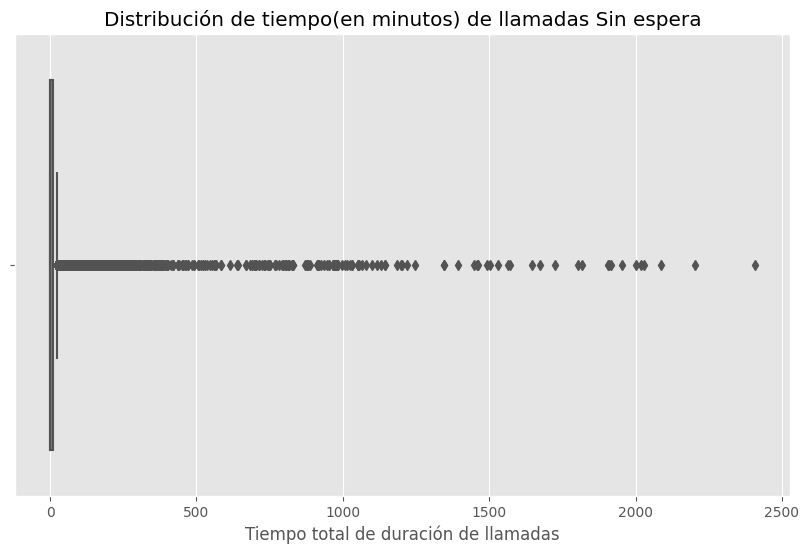

In [27]:
# investigar valores atipicos del tiempo de llamadas
with plt.style.context('ggplot'):
    # crear boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(data=calls, x='call_duration_min')
    
    plt.title('Distribución de tiempo(en minutos) de llamadas Sin espera')
    plt.xlabel('Tiempo total de duración de llamadas')
              
    plt.show()

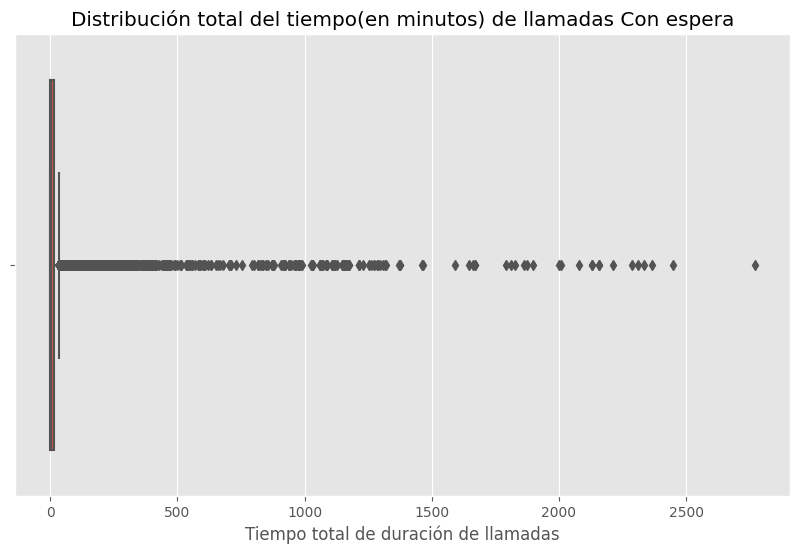

In [28]:
# investigar valores atipicos del tiempo de llamadas
with plt.style.context('ggplot'):
    # crear boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(data=calls, x='total_call_duration_min')
    
    plt.title('Distribución total del tiempo(en minutos) de llamadas Con espera')
    plt.xlabel('Tiempo total de duración de llamadas')
              
    plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
Al indagar mas sobre la distribucion de los tiempos de duración de las llamadas se encontro que existen muchos valores outliers, los cuales seran tratados mas adelante para realizar el analisis.
</span>

## Distribución de llamadas 

### Distribución de llamadas entrantes y salientes por día 

In [29]:
# agrupar llamadas al día por direccion de llamada
direction_day = calls.groupby(['calls_day', 'direction'])['calls_count'].count().unstack()

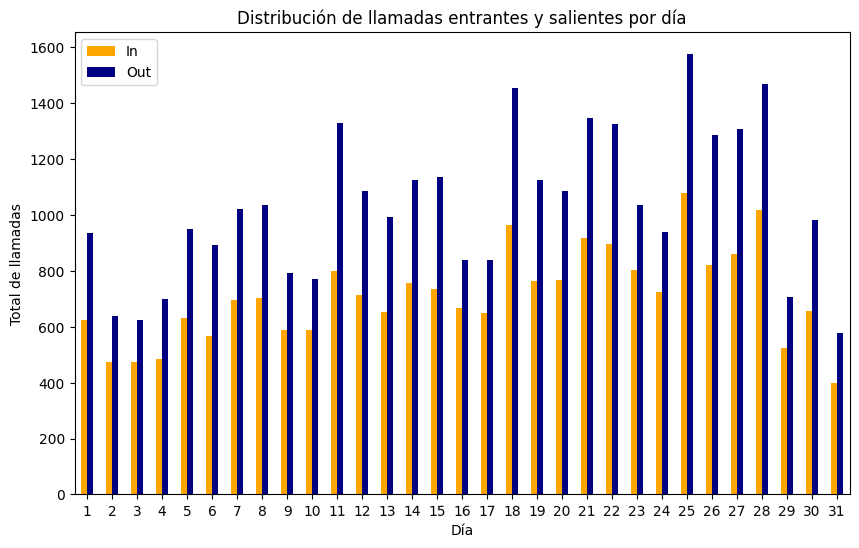

In [30]:
# Gráfico de llamadas entrantes y salientes por dia
direction_day.plot(
    kind='bar',
    figsize=(10,6),
    rot=1, 
    color=['orange', 'navy'])

plt.title('Distribución de llamadas entrantes y salientes por día')
plt.xlabel('Día')
plt.ylabel('Total de llamadas')
plt.legend(['In','Out'])
plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En el grafico anterior se observa la distribucion de llamadas entrantes y salientes por dia, en donde se observa que las llamadas salientes son mayores.
</span>

### Distribución de llamadas entrantes y salientes por semana

In [31]:
# agrupar llamadas a la semana por direccion de llamada
direction_week = calls.groupby(['calls_week', 'direction'])['calls_count'].count().unstack()

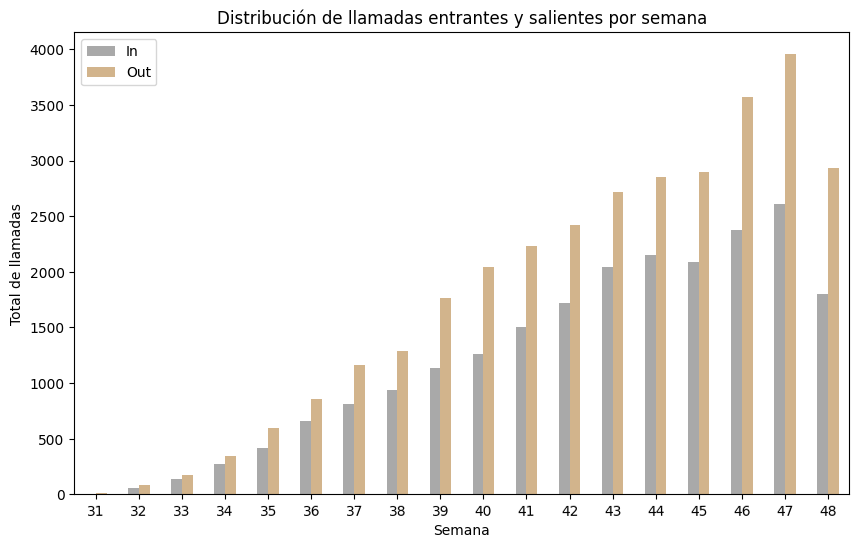

In [32]:
# grafico de llamadas entrastes y salientes a la semana
direction_week.plot(
    kind='bar',
    figsize=(10,6),
    rot=1, 
    color=['darkgray', 'tan'])

plt.title('Distribución de llamadas entrantes y salientes por semana')
plt.xlabel('Semana')
plt.ylabel('Total de llamadas')
plt.legend(['In','Out'])
plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En este grafico se observa la cantidad de llamadas realizadas por semana, y de igual manera las llamadas salientes tienen una mayor presencia.
</span>

### Distribución de llamadas entrantes y salientes por mes 

In [33]:
# agrupar llamadas al mes por direccion de llamada
direction_month = calls.groupby(['calls_month', 'direction'])['calls_count'].count().unstack()

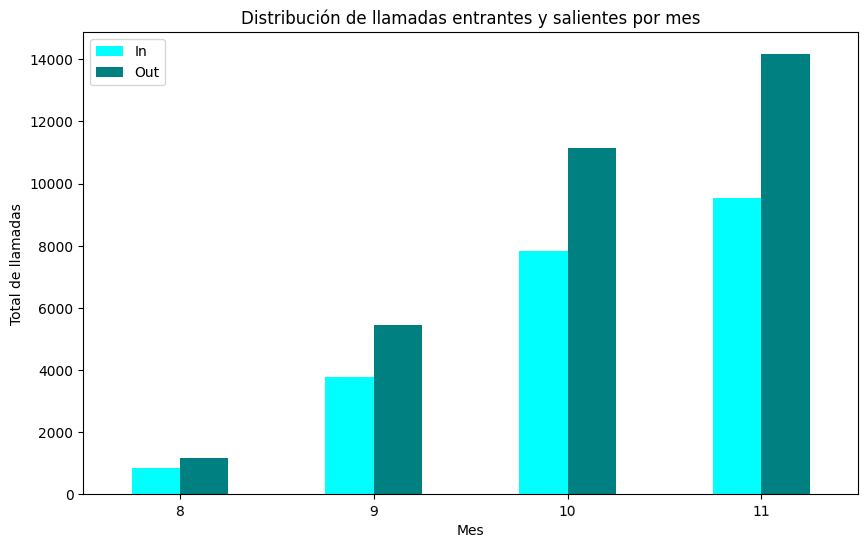

In [34]:
# Gráfico de llamadas entrantes y salientes por mes 
direction_month.plot(
    kind='bar',
    figsize=(10,6),
    rot=1, 
    color=['aqua', 'teal'])

plt.title('Distribución de llamadas entrantes y salientes por mes')
plt.xlabel('Mes')
plt.ylabel('Total de llamadas')
plt.legend(['In','Out'])
plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En este ultimo grafico se hace nuevamente una comparación de las llamadas recibidas al mes y donde nuevamente las llamadas salientes son las que mayormente se realizan
</span>

## Distribución de llamadas salientes y entrantes por operador

### Número de llamadas salientes (out) por operador al día 

In [35]:
# filtro llamadas Out 
call_out = calls.query('direction == "out"')

# filtro llamadas In 
call_in = calls.query('direction == "in"')

In [36]:
# calcular el numero de llamadas salientes que realizo el operador por dia 
calls_operator_day = call_out.groupby([
    'calls_day', 'operator_id'])['calls_count'].sum().reset_index(name='num_calls')
# ordenar descendentemente
calls_operator_day.sort_values(by='num_calls', ascending=False)

,calls_day,operator_id,num_calls
3424,11,929428,5029
10,1,885876,4360
7908,23,885876,3950
5202,16,885890,3349
2882,10,885876,3328
...,...,...,...
6719,20,900788,1
6718,20,900746,1
6717,20,900742,1
6716,20,900614,1


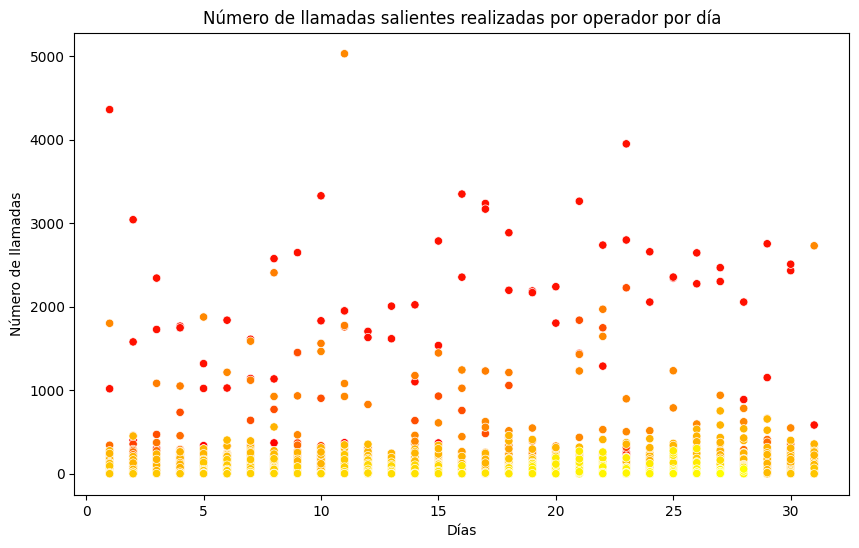

In [37]:
# grafico de llamadas salientes por operador al dia
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='calls_day',
    y='num_calls',
    data= calls_operator_day,
    hue='operator_id',
    palette='autumn', 
    legend=False)
plt.title('Número de llamadas salientes realizadas por operador por día')
plt.xlabel('Días')
plt.ylabel('Número de llamadas')

plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En este grafico de dispersión se muestra el numero de llamadas salientes por dia y por operador, en el se puede observar que la gran parte de los datos se encuentran por debajo de las 1000 llamadas y solo algunos operadores lograron superar este umbral
</span>

### Número de llamadas salientes (out) por operador a la semana

In [38]:
# calcular el numero de llamadas salientes que realizo el operador por semana
calls_operator_week = call_out.groupby([
    'calls_week', 'operator_id'])['calls_count'].sum().reset_index(name='num_calls')
# ordenar descendentemente
calls_operator_week.sort_values(by='num_calls', ascending=False)

,calls_week,operator_id,num_calls
690,39,885876,11062
342,37,885876,9141
1443,41,925922,8701
507,38,885876,8286
936,40,885876,8163
...,...,...,...
2798,45,920902,1
4147,48,927142,1
2799,45,921102,1
1264,41,900592,1


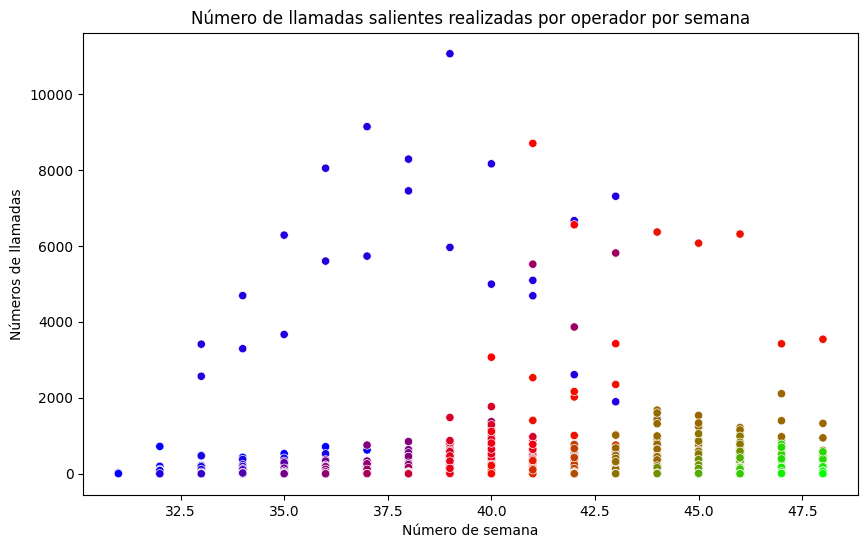

In [39]:
# grafico de llamdas salientes por operador al dia
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='calls_week',
    y='num_calls',
    data= calls_operator_week, 
    hue='operator_id',
    palette='brg', 
    legend=False)
plt.title('Número de llamadas salientes realizadas por operador por semana')
plt.xlabel('Número de semana')
plt.ylabel('Números de llamadas')

plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En este otro grafico de dispersión se observa que en las semanas 40 a 45 se realizaron mas llamadas por los operadores, sin embargo, el numero de estas no rebasa las 2000 llamadas, solo algunos operadores puedieron superar las 8000  y solo 1 las 10,000.
</span>

### Número de llamadas salientes (out) por operador al mes

In [40]:
# calcular el numero de llamadas salientes que realizo el operador por mes
calls_operator_month = call_out.groupby([
    'calls_month', 'operator_id'])['calls_count'].sum().reset_index(name='num_calls')
# ordenar descendentemente
calls_operator_month.sort_values(by='num_calls', ascending=False)

,calls_month,operator_id,num_calls
133,9,885876,38601
134,9,885890,25599
478,10,885890,24686
802,10,925922,21754
640,10,908640,16571
...,...,...,...
948,10,940440,1
957,10,940610,1
965,10,940842,1
1342,11,936296,1


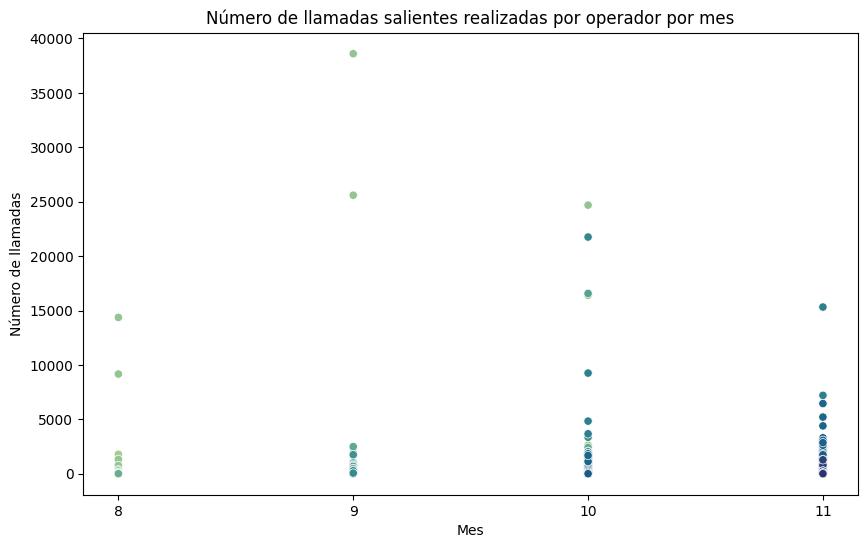

In [41]:
# grafico de llamadas salientes por operador al dia
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='calls_month',
    y='num_calls',
    data= calls_operator_month,
    hue='operator_id',
    palette='crest',
    legend=False)
plt.title('Número de llamadas salientes realizadas por operador por mes')
plt.xlabel('Mes')
plt.ylabel('Número de llamadas')

# Ajustar los ticks del eje x para eliminar decimales
plt.xticks(ticks=range(int(calls_operator_month['calls_month'].min()), 
                       int(calls_operator_month['calls_month'].max()) + 1))

plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En este grafico se muestra el total de llamadas por mes por operador, en donde se observa claramente que el mes con mayor actividad es Noviembre, aunque en los meses anteriores se llegan a observar valores outliers, estos son minimos y no podrian marcar una gran diferencia en el análisis.
</span>

## Llamadas y tiempos generales por operador

In [42]:
# crear DF con el total de llamadas, llamadas promedio y numero de llamadas perdidas por operador
df_call = calls.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', 'count'),
    time_without_wait = ('call_duration_min', 'sum'),
    time_with_wait = ('total_call_duration_min', sum)
).reset_index()

In [43]:
df_call

,operator_id,total_calls,missed_calls,time_without_wait,time_with_wait
0,879896,1131,128,1387.71,1623.74
1,879898,7974,251,4647.97,6530.84
2,880020,54,22,38.17,43.75
3,880022,219,76,305.03,377.98
4,880026,2439,198,2827.96,3227.75
...,...,...,...,...,...
1087,972410,77,4,62.95,87.91
1088,972412,61,5,58.30,75.80
1089,972460,70,9,38.68,52.03
1090,973120,3,2,0.08,0.42


In [44]:
# graficar las llamadas totales y las llamadas perdidas por operador al mes
graf_missed_call = calls.groupby(['operator_id','direction','calls_month']).agg(
    total_call = ('calls_count', 'sum'),
    missed_call= ('is_missed_call', 'count')
).reset_index()

In [45]:
# usar el metodo melt para convertir el tipo de llamadas en una columna
graf_melted = graf_missed_call.melt(
    id_vars=['calls_month', 'direction'],
    value_vars=['total_call', 'missed_call'],
    var_name='call_type', 
    value_name='call_count'
)

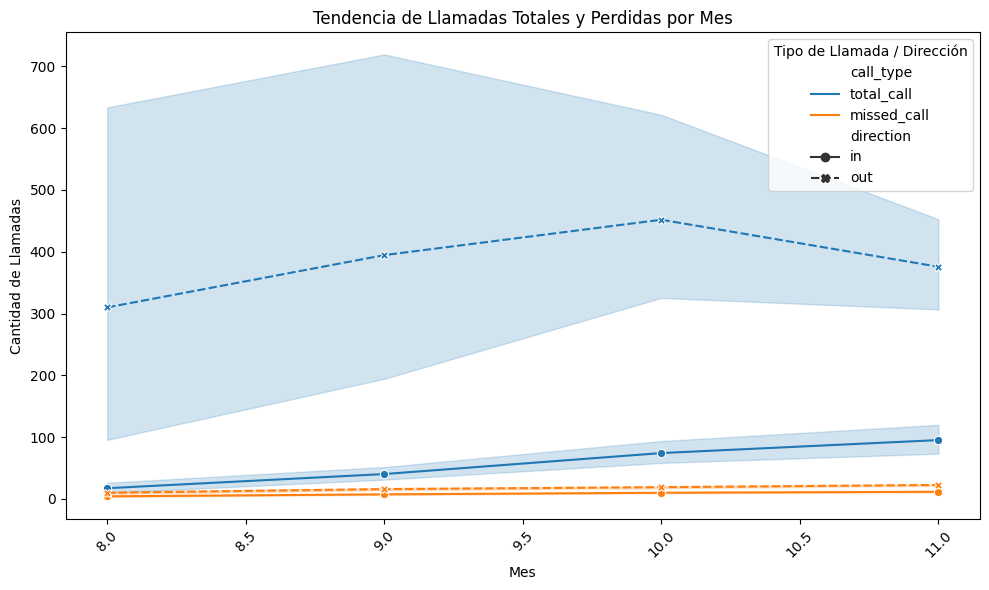

In [46]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data=graf_melted, 
             x='calls_month',
             y='call_count',
             hue='call_type',
             style='direction',
             markers=True)

plt.title("Tendencia de Llamadas Totales y Perdidas por Mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad de Llamadas")
plt.legend(title="Tipo de Llamada / Dirección")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En este grafico se muestra el total de llamadas y total de llamadas perdidas por direccion, en donde se observa que hay un gran numero de llamadas salientes y pocas llamadas entrantes a lo largo de los meses, mientras la cantidad de llamadas perdidas es minima y no se observan grandes diferencias entre llamadas salientes y entrantes.
</span>

### Llamadas entrantes (In) por operador

In [47]:
df_call_in = call_in.groupby('operator_id').agg(
    total_call_in = ('calls_count', 'sum'),
    missed_call_in = ('is_missed_call', 'count'),
    avg_without_wait = ('call_duration_min', 'mean'),
    avg_with_wait = ('total_call_duration_min', 'mean')
).reset_index()

In [48]:
df_call_in

,operator_id,total_call_in,missed_call_in,avg_without_wait,avg_with_wait
0,879896,60,23,4.102609,4.551304
1,879898,118,64,1.837500,2.307031
2,880020,8,8,0.716250,0.840000
3,880022,8,8,1.066250,1.298750
4,880026,25,19,1.432105,1.563684
...,...,...,...,...,...
749,971102,78,5,35.428000,39.994000
750,971354,6,2,6.190000,6.895000
751,972412,1,1,2.000000,2.420000
752,972460,2,2,0.230000,0.300000


### Llamadas salientes (Out)  por operador 

In [49]:
df_call_out = call_out.groupby('operator_id').agg(
    total_call_out = ('calls_count', 'sum'),
    missed_call_out = ('is_missed_call', 'count'),
    avg_without_wait = ('call_duration_min', 'mean'),
    avg_with_wait = ('total_call_duration_min', 'mean')
).reset_index()

In [50]:
df_call_out

,operator_id,total_call_out,missed_call_out,avg_without_wait,avg_with_wait
0,879896,1071,105,12.317619,14.467238
1,879898,7856,187,24.226578,34.134706
2,880020,46,14,2.317143,2.645000
3,880022,211,68,4.360294,5.405735
4,880026,2414,179,15.646648,17.866145
...,...,...,...,...,...
877,972408,8,3,1.110000,1.526667
878,972410,77,4,15.737500,21.977500
879,972412,60,4,14.075000,18.345000
880,972460,68,7,5.460000,7.347143


## Operadores ineficientes

In [51]:
# calcular indice de ineficacia con: gran cantidad llamadas entrantes perdidas, tiempo prolongado para las llamadas
# entrantes, numero reducido de llamadas salientes

df_combinado = df_call_in.merge(df_call_out, 
                                   on='operator_id', 
                                   how='outer', 
                                suffixes=('_in', '_out'))

In [52]:
# calcular la proporcion de llamadas entrantes perdidas
df_combinado['missed_calls_ratio'] = df_combinado['missed_call_in'] / df_combinado['total_call_in']

In [53]:
# calcular diferencia promedio de tiempo con y sin espera de llamadas entrantes
df_combinado['wait_time_difference'] = df_combinado['avg_with_wait_in'] - df_combinado['avg_without_wait_in']

In [54]:
# calcular el promedio total de llamadas salientes por operador
total_mean_calls_out = df_combinado['total_call_out'].mean()

# calcular la proporcion de llamadas salientes con respecto al promedio total
df_combinado['calls_out_ratio'] = df_combinado['total_call_out'] / total_mean_calls_out

In [55]:
# establecer pesos para las metricas segun la importancia relativa
# peso para proporcion de llamadas perdidas
w1 = 0.4
# peso para la diferencia de tiempo de espera 
w2 = 0.4
# peso para la proporcion de llamadas salientes
w3 = 0.2

In [56]:
# calcular el indice de ineficacia
df_combinado['inefficiency_index'] = (
    w1 * df_combinado['missed_calls_ratio'] +
    w2 * df_combinado['wait_time_difference'] -
    w3 * df_combinado['calls_out_ratio']
)

In [57]:
df_combinado = df_combinado.sort_values(by='inefficiency_index', ascending=False)

In [58]:
# mostrar metricas relevantes
df_combinado[['operator_id', 'inefficiency_index', 'missed_calls_ratio', 'wait_time_difference', 'calls_out_ratio']].head(10)

,operator_id,inefficiency_index,missed_calls_ratio,wait_time_difference,calls_out_ratio
337,919794,6.936429,0.027882,17.327027,0.027672
206,906070,5.682523,0.044321,14.220625,0.117276
335,919790,5.607955,0.039598,13.996761,0.032943
207,906076,4.111070,0.083333,10.195000,0.001318
328,919204,3.864684,0.013751,9.653889,0.011859
333,919552,3.717983,0.061340,9.279737,0.092240
445,931458,3.703330,0.025834,10.919818,3.374655
334,919554,3.475321,0.062407,8.635119,0.018448
288,913938,3.458865,0.016089,8.918333,0.574522
358,921318,3.304407,0.024145,10.123833,3.773922


<span style="color:purple; font-weight:bold; font-size: 18px">
Para calcular el indice general de ineficacia se consideraron 3 metricas relacionadas con el objetivo del proyecto, la primera consistio en calcular el promedio de llamadas perdidas, la segunda el tiempo de espera y por ultimo el promedio de llamadas salientes hechas por el operador. De esta manera se asigno un peso a cada una de las metricas y se calculo el indice de ineficacia, lo que dio como resultado que el operador 919794 es quien cuenta con un gran indice de ineficacia con un 2% de llamadas perdidas, un promedio de 17 minutos de tiempo de espera por llamada y un 2% de llamadas salientes.
</span>

## Operadores por tipo de plan

In [59]:
# unir los dos Datasets
plan_id = clients.merge(calls, on ='user_id', how='outer')

In [60]:
# crear columna con tiempo de espera en minutos 
plan_id['wait_time'] = plan_id['total_call_duration_min'] - plan_id['call_duration_min']

In [61]:
# identificar cuantos planes existen
plan_id['tariff_plan'].unique()

array(['A', 'C', 'B'], dtype=object)

In [62]:
# Segmentar por tipo de plan 
plan_a = plan_id[plan_id ['tariff_plan'] == 'A']
plan_b = plan_id[plan_id ['tariff_plan'] == 'B']
plan_c = plan_id[plan_id ['tariff_plan'] == 'C']

### Metricas operadores tarifa A

In [63]:
# calcular las metricas objetivo
operator_a = plan_a.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', 'count'),
    time_wait=('wait_time', 'sum')
).reset_index()

In [64]:
# calcular metrica de llamadas perdidas por operador del plan A
operator_a['missed_call_rate'] = operator_a['missed_calls'] / operator_a['total_calls']

# calcular metrica de tiempo de espera por operador del plan A
operator_a['avg_time_call'] = operator_a['time_wait'] / operator_a['total_calls']

In [65]:
operator_a

,operator_id,total_calls,missed_calls,time_wait,missed_call_rate,avg_time_call
0,884294,1.0,1,0.10,1.000000,0.100000
1,885876,66049.0,319,25606.24,0.004830,0.387686
2,885890,66016.0,277,26440.27,0.004196,0.400513
3,886146,52.0,19,19.24,0.365385,0.370000
4,887992,47.0,6,11.33,0.127660,0.241064
...,...,...,...,...,...,...
305,965542,776.0,14,298.74,0.018041,0.384974
306,965544,1277.0,13,417.82,0.010180,0.327189
307,966686,3.0,2,0.72,0.666667,0.240000
308,968232,1.0,1,0.22,1.000000,0.220000


### Metricas operadores tarifa B

In [66]:
# calcular las metricas objetivo
operator_b = plan_b.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', 'count'),
    time_wait=('wait_time', 'sum')
).reset_index()

In [67]:
# calcular metrica de llamadas perdidas por operador del plan B
operator_b['missed_call_rate'] = operator_b['missed_calls'] / operator_b['total_calls']

# calcular metrica de tiempo de espera por operador del plan B
operator_b['avg_time_call'] = operator_b['time_wait'] / operator_b['total_calls']

In [68]:
operator_b

,operator_id,total_calls,missed_calls,time_wait,missed_call_rate,avg_time_call
0,879896,1131.0,128,236.03,0.113174,0.208691
1,879898,7974.0,251,1882.87,0.031477,0.236126
2,880020,54.0,22,5.58,0.407407,0.103333
3,880022,219.0,76,72.95,0.347032,0.333105
4,880026,2439.0,198,399.79,0.081181,0.163916
...,...,...,...,...,...,...
390,971354,6.0,2,1.41,0.333333,0.235000
391,972408,8.0,3,1.25,0.375000,0.156250
392,972410,77.0,4,24.96,0.051948,0.324156
393,972412,61.0,5,17.50,0.081967,0.286885


### Metricas operadores tarifa C

In [69]:
# calcular las metricas objetivo
operator_c = plan_c.groupby('operator_id').agg(
    total_calls=('calls_count', 'sum'),
    missed_calls=('is_missed_call', 'count'),
    time_wait=('wait_time', 'sum')
).reset_index()

In [70]:
# calcular metrica de llamadas perdidas por operador del plan C
operator_c['missed_call_rate'] = operator_c['missed_calls'] / operator_c['total_calls']

# calcular metrica de tiempo de espera por operador del plan C
operator_c['avg_time_call'] = operator_c['time_wait'] / operator_c['total_calls']

In [71]:
operator_c

,operator_id,total_calls,missed_calls,time_wait,missed_call_rate,avg_time_call
0,882476,3.0,3,1.57,1.000000,0.523333
1,882478,4.0,3,1.39,0.750000,0.347500
2,883018,2.0,1,0.25,0.500000,0.125000
3,883898,1.0,1,0.16,1.000000,0.160000
4,884946,2042.0,92,739.54,0.045054,0.362165
...,...,...,...,...,...,...
382,969600,29.0,3,6.51,0.103448,0.224483
383,971100,3.0,2,0.43,0.666667,0.143333
384,971102,78.0,5,22.83,0.064103,0.292692
385,972460,70.0,9,13.35,0.128571,0.190714


<span style="color:purple; font-weight:bold; font-size: 18px">
Despues se obtuvieron las metricas de los operadores por tipo de plan, esto con la finalidad de mostrar que operadores son los menos eficaces y que grupo atienden.
</span>

## Operadores ineficaces por plan

In [72]:
# concatenar los resultados de cada plan 
operators_all = pd.concat([operator_a,operator_b,operator_c])

In [73]:
# establecer umbrales por para llamadas perdidas y tiempo promedio de llamadas
missed_umbral = operators_all['missed_calls'].quantile(0.75)

avg_time_umbral = operators_all['avg_time_call'].quantile(0.75)

print(f"Umbral para missed_call_rate: {missed_umbral}")
print(f"Umbral para avg_time_call: {avg_time_umbral}")

Umbral para missed_call_rate: 54.25
Umbral para avg_time_call: 0.33357142857142863


In [74]:
# funcion para etiquetar operadores ineficientes 
def inefficiency_operator(df, missed_call_umbral, time_umbral):
    df['inefficient'] = (
        (df['missed_call_rate'] > missed_call_umbral) | 
        (df['avg_time_call'] > time_umbral)
    )
    return df

In [75]:
# operadores ineficaces etiquetados si rebasaron los umbrales
operator_a = inefficiency_operator(operator_a, missed_umbral, avg_time_umbral)
operator_b = inefficiency_operator(operator_b, missed_umbral, avg_time_umbral)
operator_c = inefficiency_operator(operator_c, missed_umbral, avg_time_umbral)

In [76]:
# funcion para calcular la proporcion de operadores ineficaces 
def inefficiency_total(df):
    total_operators = len(df)
    inefficient_operator = df['inefficient'].sum()
    inefficient_rate = inefficient_operator / total_operators
    avg_time = df['time_wait'].mean()
    
    return pd.Series({
        'total_operator': total_operators,
        'inefficient_operator': inefficient_operator,
        'inefficient_rate' : inefficient_rate,
        'avg_wait_time' : avg_time
    })

In [77]:
# llamar a la funcion para calcular el total de operadores, operadores ineficaces y promedio de operadores
operator_total_a = inefficiency_total(operator_a)
operator_total_b = inefficiency_total(operator_b)
operator_total_c = inefficiency_total(operator_c)

In [78]:
# crear DF con los totales de operadores ineficaces por cada plan de tarifa
df_operators_inefficents = pd.DataFrame({
    'Plan': ['A', 'B', 'C'],
    'Total Operators': [operator_total_a['total_operator'], 
                        operator_total_b['total_operator'], 
                        operator_total_c['total_operator']],
    'Inefficient Operators': [operator_total_a['inefficient_operator'], 
                               operator_total_b['inefficient_operator'], 
                               operator_total_c['inefficient_operator']],
    'Inefficiency Rate (%)': [operator_total_a['inefficient_rate'] * 100, 
                              operator_total_b['inefficient_rate'] * 100, 
                              operator_total_c['inefficient_rate'] * 100],
    'Average_wait_time' : [operator_total_a['avg_wait_time'],
                          operator_total_b['avg_wait_time'],
                          operator_total_c['avg_wait_time']]
})

In [79]:
df_operators_inefficents

,Plan,Total Operators,Inefficient Operators,Inefficiency Rate (%),Average_wait_time
0,A,310.0,98.0,31.612903,457.163645
1,B,395.0,95.0,24.050633,109.647468
2,C,387.0,80.0,20.671835,137.085478


<span style="color:purple; font-weight:bold; font-size: 18px">
Para determinar qué operadores son más eficientes y cuáles no, se establecieron umbrales utilizando los percentiles de la muestra, dado que la presencia de valores atípicos podría sesgar los resultados al calcular medidas de tendencia central como la media o la mediana. Se tomó en cuenta el percentil 75 como referencia, y los hallazgos son los siguientes:

* Grupo A: Se identificaron 310 operadores, de los cuales 98 fueron clasificados como ineficientes, representando un 31% de ineficacia, con un tiempo de espera promedio de 457 minutos para este grupo.
    
* Grupo B: De 395 operadores, 95 se consideraron ineficaces, lo que equivale al 24% de ineficacia, con un tiempo de espera promedio de 109 minutos.
    
* Grupo C: En este grupo, compuesto por 387 operadores, 80 se identificaron como ineficaces, representando el 20% de ineficacia. El tiempo de espera promedio para este grupo fue de 137 minutos.
    
Estos resultados resaltan las diferencias en la eficiencia entre los grupos, siendo el grupo C el más eficiente en términos de porcentaje de ineficacia, mientras que el grupo A presenta los mayores tiempos de espera y la mayor proporción de operadores ineficientes.
</span>

## Prueba de hipótesis estadísticas

### Comparación entre los tiempos de espera de los planes tarifarios

#### Hipótesis Nula: No existen diferencias significativas entre los tiempos de espera de los distintos planes
#### Hipótesis Alternativa: Existen diferencias significativas (al menos en una) entre los tiempos de espera de los distintos planes

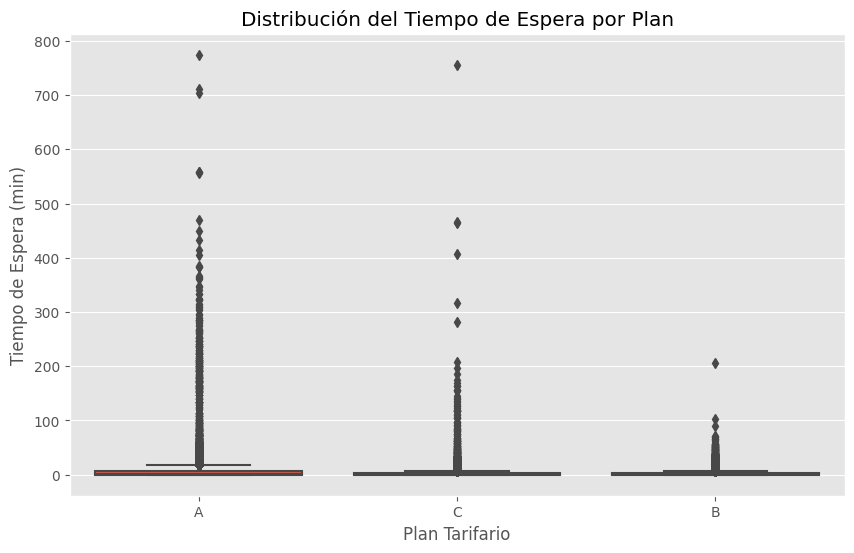

In [80]:
# Verificar normalidad con un boxplot 
with plt.style.context('ggplot'):
    # crear boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(data=plan_id, x='tariff_plan', y='wait_time')

    plt.title('Distribución del Tiempo de Espera por Plan')
    plt.xlabel('Plan Tarifario')
    plt.ylabel('Tiempo de Espera (min)')
    
plt.show()


In [81]:
# verificar valores nulos
plan_id['wait_time'].isna().sum()

425

In [82]:
# dividir los tiempos de espera por cada plan y eliminar valores nulos
wait_time_a = plan_id[(plan_id['tariff_plan'] == 'A') & (plan_id['wait_time'].notna())]['wait_time']
wait_time_b = plan_id[(plan_id['tariff_plan'] == 'B') & (plan_id['wait_time'].notna())]['wait_time']
wait_time_c = plan_id[(plan_id['tariff_plan'] == 'C') & (plan_id['wait_time'].notna())]['wait_time']

In [83]:
# aplicar prueba Kruskal-Wallis
stat, p_value = kruskal(wait_time_a, wait_time_b, wait_time_c)

# mostrar resultados
print(f'Estadístico de Kruskal-Wallis: {stat}')
print(f'Valor p: {p_value}')

if p_value < 0.05:
    print("Hay diferencias significativas entre los planes.")
else:
    print("No hay diferencias significativas entre los planes.")

Estadístico de Kruskal-Wallis: 859.5024452639879
Valor p: 2.2983460553686325e-187
Hay diferencias significativas entre los planes.


<span style="color:purple; font-weight:bold; font-size: 18px">
Para comprobar esta hipótesis se realizó una prueba de Kruskal-Wallis para comparar los tiempos de espera promedio entre los tres grupos (planes). El estadístico de Kruskal-Wallis obtenido fue 859.50, y el valor p asociado fue 2.30e-187, lo cual es mucho menor que el nivel de significancia establecido de 0.05.

Esto indica que hay evidencia estadísticamente significativa para concluir que al menos uno de los grupos difiere de los otros en términos de los tiempos de espera promedio.
</span>

### Diferencia entre el tiempo de espera promedio de operadores más eficaces y menos eficaces

#### Hipótesis Nula: No existen diferencias significativas en el tiempo de espera promedio entre los operadores más eficaces y los menos eficaces

#### Hipótesis Alternativa: Existen diferencias significativas en el tiempo de espera promedio entre los operadores más eficaces de los menos eficaces

In [84]:
# calcular el tiempo promedio de operadores 
avg_time_operator = calls.groupby('operator_id')['total_call_duration_min'].mean()

In [85]:
avg_time_operator.sort_values(ascending=False)

operator_id
885876    323.946270
885890    316.098087
925922    294.455949
908640    160.350000
929428    158.660429
             ...    
955068      0.000000
914626      0.000000
960674      0.000000
946454      0.000000
958458      0.000000
Name: total_call_duration_min, Length: 1092, dtype: float64

In [86]:
# obtener calculos estadisticos 
print('El tiempo maximo es de:', avg_time_operator.max())
print('El tiempo minimo es de:', avg_time_operator.min())
print('La media es:', avg_time_operator.mean())
print('La mediana es:',avg_time_operator.median())

El tiempo maximo es de: 323.94626959247637
El tiempo minimo es de: 0.0
La media es: 14.394250680923752
La mediana es: 4.898895833333333


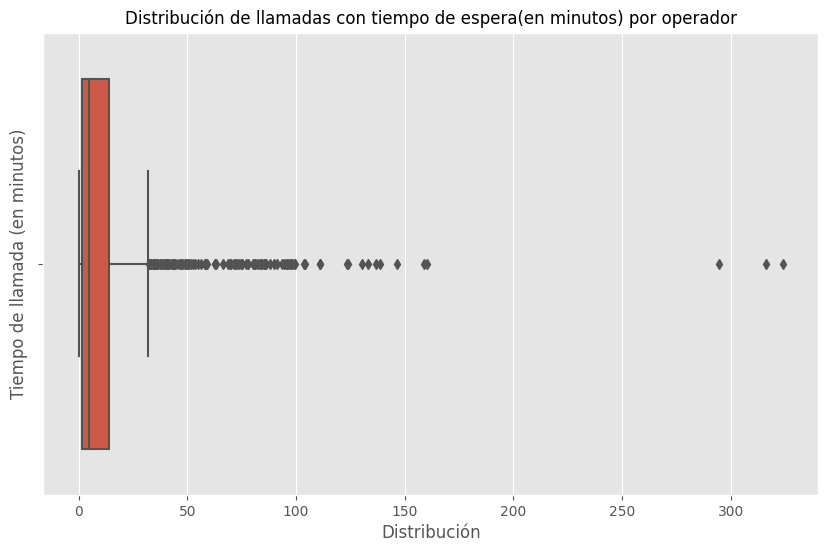

In [87]:
# diagrama caja y bigote para conocer la distribución de los datos
data = calls.groupby('operator_id')['total_call_duration_min'].mean().reset_index(name='avg_time')

# grafico
with plt.style.context('ggplot'):
    # crear boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(data=data, x='avg_time')

plt.title('Distribución de llamadas con tiempo de espera(en minutos) por operador')
plt.xlabel('Distribución')
plt.ylabel('Tiempo de llamada (en minutos)')

plt.show()

In [88]:
# calcular percentiles de la distribucion 
print(np.percentile(avg_time_operator, [25,50,75]))

[ 1.812375    4.89889583 13.87281392]


In [89]:
# definir a los operadores mas eficaces
more_efficents = avg_time_operator[(avg_time_operator >= 4.89) & (avg_time_operator <= 13.87)]

less_inefficents = avg_time_operator[avg_time_operator > 13.87]

<span style="color:purple; font-weight:bold; font-size: 18px">
Para evaluar si existe una diferencia significativa en el tiempo de espera promedio entre operadores mas eficaces y menos eficaces se clasificaron los operadores: 

* Operadores más eficaces: Aquellos cuyo tiempo promedio de espera se encuentra entre los percentiles 50 y 75 (valores entre 4.89 y 13.87 minutos).
* Operadores menos eficaces: Aquellos cuyo tiempo promedio de espera es mayor a 13.87 minutos (superior al percentil 75).
</span>

In [90]:
# extraer los valores de cada categoria 
values_efficents = more_efficents.values
values_inefficents = less_inefficents.values

In [91]:
# aplicar prueba U de maan 
stat, p_value = mannwhitneyu(values_efficents, values_inefficents)

# Mostrar resultado
print(f'Valor p: {p_value}')

if p_value < 0.05:
    print("Hay diferencias significativas entre los operadores más eficaces y menos eficaces.")
else:
    print("No hay diferencias significativas entre los operadores más eficaces y menos eficaces.")

Valor p: 4.7352597550758344e-91
Hay diferencias significativas entre los operadores más eficaces y menos eficaces.


<span style="color:purple; font-weight:bold; font-size: 18px">
Se aplicó la prueba U de Mann-Whitney, se obtuvo un valor p de 4.735e-91 es significativamente menor que 0.05, se rechaza la hipótesis nula. Esto indica que hay evidencia estadísticamente significativa para concluir que existe una diferencia en el tiempo de espera promedio entre los operadores más eficaces y los menos eficaces.
</span>

### Tiempo promedio de operadores con más llamadas perdidas y menos llamadas perdidas

#### Hipótesis nula: No hay diferencias significativas en el tiempo promedio de espera entre operadores con más y menos llamadas perdidas.

#### Hipótesis alternativa: Hay diferencias significativas en el tiempo promedio de espera entre operadores con más y menos llamadas perdidas.

In [92]:
# agrupacion de operadores por llamadas perdidas y tiempo con espera 
time_calls_missed = calls.groupby('operator_id').agg(
    total_missed_call=('is_missed_call', 'count'),
    avg_wait_time=('total_call_duration_min', 'mean')
).reset_index()

In [93]:
# obtener calculos estadisticos de las llamadas perdidas
print('Las llamadas maximas son:', time_calls_missed['total_missed_call'].max())
print('Las llamadas minimas son:', time_calls_missed['total_missed_call'].min())
print('La media es:', time_calls_missed['total_missed_call'].mean())
print('La mediana es:',time_calls_missed['total_missed_call'].median())

Las llamadas maximas son: 348
Las llamadas minimas son: 1
La media es: 41.87728937728938
La mediana es: 21.0


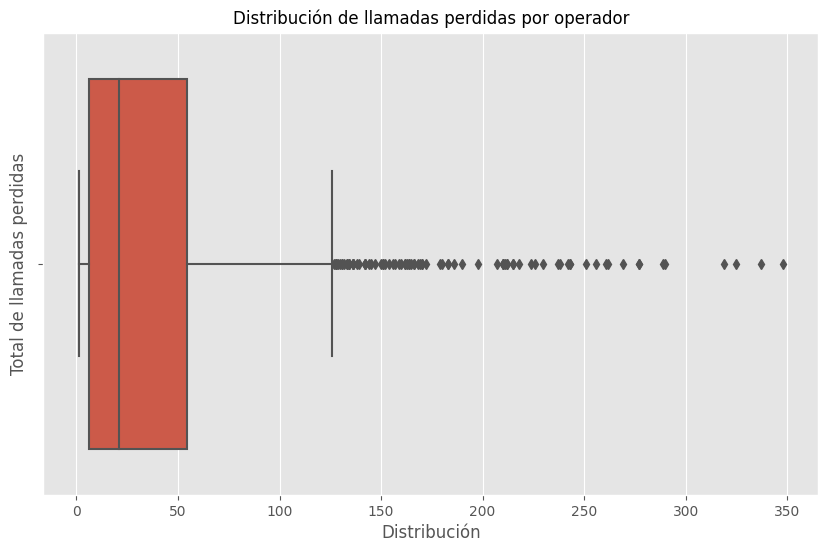

In [94]:
# diagrama caja y bigote para conocer la distribución de las llamadas perdidas

with plt.style.context('ggplot'):
    # crear boxplot
    plt.figure(figsize=(10,6))
    sns.boxplot(data=time_calls_missed, x='total_missed_call')

plt.title('Distribución de llamadas perdidas por operador')
plt.xlabel('Distribución')
plt.ylabel('Total de llamadas perdidas')

plt.show()

In [95]:
# definir umbrales por percentiles
percentile_75 = time_calls_missed['total_missed_call'].quantile(0.75)
percentile_25 = time_calls_missed['total_missed_call'].quantile(0.25)

print(f"Percentil 25: {percentile_25}, Percentil 75: {percentile_75}")

Percentil 25: 6.0, Percentil 75: 54.25


In [96]:
# segmentar por operadores con mas llamadas perdidas y menos llamadas perdidas 
more_missed_call = time_calls_missed[time_calls_missed['total_missed_call'] > percentile_75]

less_missed_call = time_calls_missed[time_calls_missed['total_missed_call'] <= percentile_25]

<span style="color:purple; font-weight:bold; font-size: 18px">
Para probar la hipotesis: tiempo promedio de operadores con más llamadas perdidas y menos llamadas perdidas, se analizó la distribución de las llamadas perdidas, calculando medidas de tendencia central como la media y la mediana, ademas de valores maximos y minimos, dando una distribucion no normal, por lo cual se opto por utilizar los percentiles 25 y 75 de la muestra, clasificando las llamadas perdidas de la siguiente forma:
    
* Menos llamadas perdidas: Aquellas cuya cantidad se encuentra por debajo del percentil 25 (menos de 6 llamadas).
* Mas llamadas perdidas: Aquellas cuya cantidad se encuentra por encima del percentil 75 (mas de 54 llamadas).
 
</span>

In [97]:
# mostrar las primeras filas de los grupos
print("Operadores con más llamadas perdidas:")
print(more_missed_call.head())

print("\nOperadores con menos llamadas perdidas:")
print(less_missed_call.head())

Operadores con más llamadas perdidas:
   operator_id  total_missed_call  avg_wait_time
0       879896                128      12.685469
1       879898                251      26.019283
3       880022                 76       4.973421
4       880026                198      16.301768
5       880028                226      15.947655

Operadores con menos llamadas perdidas:
    operator_id  total_missed_call  avg_wait_time
8        882476                  3       1.593333
9        882478                  3       0.840000
15       883018                  1       0.250000
16       883898                  1       1.330000
19       884294                  1       0.180000


In [98]:
# preparar datos para la prueba, extraer tiempo promedio 
wait_times_more = more_missed_call['avg_wait_time']
wait_times_less = less_missed_call['avg_wait_time']

In [99]:
# establecer nivel de significancia
alpha = 0.05 

# aplicar prueba U de mann 
stat, p_value = mannwhitneyu(wait_times_more, wait_times_less)

# imprimir p valor 
print(f'Valor p: {p_value}')

if p_value < alpha:
    print("Hay diferencias significativas entre los grupos.")
else:
    print("No hay diferencias significativas entre los grupos.")

Valor p: 7.550856678675656e-66
Hay diferencias significativas entre los grupos.


<span style="color:purple; font-weight:bold; font-size: 18px">
Se determinó que la distribución de las llamadas perdidas no es normal, basándose en estadísticas descriptivas (media, mediana, valores máximo y mínimo).
Por esta razón, se utilizó la prueba U de Mann-Whitney, que es adecuada para comparar dos grupos independientes con distribuciones no normales. El Valor p (7.55e-66 ) obtenido es significativamente menor que 0.05, se rechaza la hipótesis nula, lo que indica que hay evidencia estadísticamente significativa para concluir que existe una diferencia en el tiempo promedio de los operadores con más llamadas perdidas y aquellos con menos llamadas perdidas.
</span>